In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
from torchsummary import summary
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # dead kernel for matplotlib

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
torch.__version__

'2.1.0'

# 데이터 전처리
* <code>.tif</code> 타입의 파일은 여러 프레임의 이미지로 구성이 되어있다.
* 현재 다루는 tif 파일은 30프레임으로 구성되어 있으며, 이를 30장으로 저장한다.
* * *
* <a href="https://appia.tistory.com/361">PIL의 유용한 속성들에 관하여</a>
* <a href='https://89douner.tistory.com/310'>프레임 단위 이미지 접근, <code>seek()</code></a>

In [4]:
DATA_PATH = './unet_dataset'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(DATA_PATH, name_label))
img_input = Image.open(os.path.join(DATA_PATH, name_input))

ny, nx = img_label.size # height, weight
nframe = img_label.n_frames
format = img_label.format

print(ny, nx, nframe, format)

512 512 30 TIFF


In [5]:
type(img_input)

PIL.TiffImagePlugin.TiffImageFile

In [6]:
# 24 : 3 : 3
nframe_train = 24
nframe_val = 3
nframe_test = 3

# 저장할 경로 설정
train_dir = os.path.join(DATA_PATH, 'train')
val_dir = os.path.join(DATA_PATH, 'val')
test_dir = os.path.join(DATA_PATH, 'test')

# 경로 폴더 만들기
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [7]:
# 데이터 랜덤 설정
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)
print(id_frame)

[ 8  3 20 29 12  7 25  4  2 22 27 18 13  9 14 24 17 15 21 10  0  6 16 11
  1  5 28 23 26 19]


In [8]:
type(img_label.seek(0))
# 내 생각
# seek()을 통해서 많은 프레임 중 인덱싱을 통한 프레임을 설정하는 거 같다.

NoneType

In [9]:
# 데이터 섞어서 train 저장
offset_nframe = 0
for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe]) # 프레임 단위로 가져오기
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(train_dir, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(train_dir, f'input_{i:03d}.npy'), input_)

In [10]:
# 데이터 섞어서 val 저장
offset_nframe += nframe_train
for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(val_dir, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(val_dir, f'input_{i:03d}.npy'), input_)

# 데이터 섞어서 test 저장
offset_nframe += nframe_val
for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])
    
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)
    
    np.save(os.path.join(test_dir, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(test_dir, f'input_{i:03d}.npy'), input_)

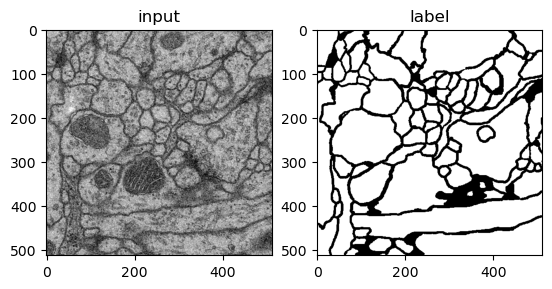

In [11]:
# 데이터 확인
# NumPy랑 Plt shape 관계는 좋은 듯함

plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.show()

In [12]:
# Assignmet Operator를 통해서 타입 변환을 하는 것은 안 된다.
# 새로 아래와 같이 MumPy를 선언해주어야 한다.

test1 = np.arange(5)
print(type(test1[0]))

test1 = test1 / 255.0
print(type(test1[0]))

<class 'numpy.int32'>
<class 'numpy.float64'>


In [13]:
# np.newaxis에 대한 테스트

test2 = np.random.rand(2, 3)

print(test2.ndim, test2.shape)

test2 = test2[:, :, np.newaxis]

print(test2.ndim, test2.shape)

2 (2, 3)
3 (2, 3, 1)


In [14]:
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform

        # 데이터 파일 리스트
        data_li = os.listdir(self.data_path)

        label_li = [f for f in data_li if f.startswith('label')]
        input_li = [f for f in data_li if f.startswith('input')]

        label_li.sort()
        input_li.sort()

        self.lst_label = label_li
        self.lst_input = input_li

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        # Numpy를 통해서 불러온다.
        # __getitem__으로 호출함에 따라 경로에서 가져오는 구조
        labels = np.load(os.path.join(self.data_path, self.lst_label[index]))
        inputs = np.load(os.path.join(self.data_path, self.lst_input[index]))

        # normalization
        labels = labels/255.0

        # tensor는 반드시 3차원이어야 하기 때문에 채널이 없는 경우 채널을 만들어준다.
        if labels.ndim == 2:
            labels = labels[:, :, np.newaxis]
        if inputs.ndim == 2:
            inputs = inputs[:, :, np.newaxis]

        data = {'inputs': inputs, 'labels': labels}

        if self.transform:
            data = self.transform(data)

        return data

In [15]:
# transform 구현
# 파이썬 3에 들어서면서 굳이 object를 상속받아서 class를 선언할 필요는 없음
class MyToTensor():
    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']

        inputs = inputs.transpose((2, 0, 1)).astype(np.float32)
        labels = labels.transpose((2, 0, 1)).astype(np.float32)

        data = {'inputs': torch.from_numpy(inputs), 'labels': torch.from_numpy(labels)}

        return data

class MyNormalization(object):
    def __init__(self, mean=0.5, std=0.5):
        # default 값은 직접 계산한 게 아니네?
        self.mean = mean
        self.std = std

    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']
        inputs = (inputs - self.mean) / self.std

        data = {'inputs': inputs, 'labels': labels}
        return data

class RandomFlip(object):
    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']

        # 50% 확률로 좌우 반전
        if np.random.rand() > 0.5:
            inputs = np.fliplr(inputs)
            labels = np.fliplr(labels)

        # 50% 상하 반전
        if np.random.rand() > 0.5:
            inputs = np.flipud(inputs)
            labels = np.fliplr(labels)

        data = {'inputs': inputs, 'labels': labels}
        return data

input shape (512, 512, 1)
label shape (512, 512, 1)


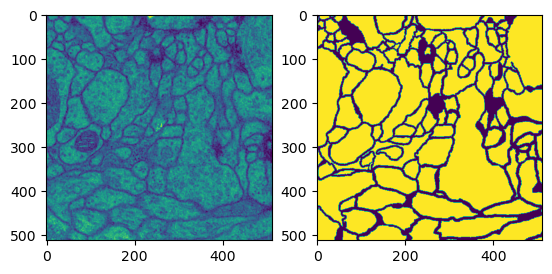

In [16]:
train_data = MyDataset(data_path=os.path.join(DATA_PATH, 'train'))
data = train_data.__getitem__(0)

inputs = data['inputs']
labels = data['labels']

print('input shape', inputs.shape)
print('label shape', labels.shape)

plt.subplot(121)
plt.imshow(inputs)
plt.subplot(122)
plt.imshow(labels)

# U-Net Model Implementation

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters):
        super().__init__()
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(out_filters)
        self.bn2 = nn.BatchNorm2d(out_filters)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_filters, out_filters):
        super().__init__()

        self.convBlk = ConvBlock(in_filters, out_filters)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.convBlk(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_filters, out_filters):
        super().__init__()
        self.transposeConv = nn.ConvTranspose2d(in_filters, out_filters, kernel_size=2, stride=2)
        self.convBlk = ConvBlock(in_filters, out_filters)
        
    def forward(self, x, skip):
        x = self.transposeConv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.convBlk(x)
        
        return x

class DobyUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Constracting Path
        self.e1 = EncoderBlock(1, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)

        # Bridge
        self.b = ConvBlock(512, 1024)

        # Expanding Path
        self.d1 = DecoderBlock(1024, 512)
        self.d2 = DecoderBlock(512, 256)
        self.d3 = DecoderBlock(256, 128)
        self.d4 = DecoderBlock(128, 64)

        self.convOut = nn.Conv2d(64, 1, kernel_size=1, stride=1)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        
        b = self.b(p4)
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        output = self.convOut(d4)
        
        return output

In [20]:
model = DobyUNet().to(device)

In [21]:
summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
         ConvBlock-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
      EncoderBlock-9  [[-1, 64, 512, 512], [-1, 64, 256, 256]]               0
           Conv2d-10        [-1, 128, 256, 256]          73,856
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 128, 256, 256]         147,584
      BatchNorm2d-14    

# 학습 준비

In [22]:
# 변수 설정
lr = 0.001
batch_size = 4
n_epoch = 100

# train model 저장 경로
ckpt_dir = './checkpoint'

# cpu or gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [23]:
# transforms
train_transform = transforms.Compose([MyNormalization(),
                                     RandomFlip(),
                                     MyToTensor()])
test_transform = transforms.Compose([MyNormalization(),
                                    MyToTensor()])

# Dataset
train_set = MyDataset(data_path=os.path.join(DATA_PATH, 'train'), transform=train_transform)
val_set = MyDataset(data_path=os.path.join(DATA_PATH, 'val'), transform=train_transform)
test_set = MyDataset(data_path=os.path.join(DATA_PATH, 'test'), transform=test_transform)

# DataLoader
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [24]:
# loss 추이 확인을 위한 변수 설정

num_data_train = len(train_set)
num_data_val = len(val_set)
num_data_test = len(test_set)

num_batch_train = np.ceil(num_data_train/batch_size)
num_batch_val = np.ceil(num_data_val/batch_size)
num_batch_test = np.ceil(num_data_test/batch_size)

In [25]:
model = DobyUNet().to(device)

loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [26]:
# 그 외 함수
tonumpy_fn = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
denorm_fn = lambda x, mean, std: (x*std)+mean
class_fn = lambda x:1.0*(x>0.5)

# 모델 저장 함수
def save_model(ckpt_dir, model, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'model': model.state_dict(),
                'optim': optim.state_dict()},
                f'./{ckpt_dir}/model_{epoch:02d}.pth')
    print(f'model_{epoch:02d}.pth save complete')

# 학습

In [27]:
# 모델 학습
for epoch in range(1, n_epoch + 1):
    model.train()
    batch_loss = []
    epoch_loss = []

    for batch, data in enumerate(train_dl, start=1):
        labels = data['labels'].to(device)
        inputs = data['inputs'].to(device)

        output = model(inputs)

        loss = loss_fn(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss 계산
        batch_loss += [loss.item()]
        batch_loss_mean = np.mean(batch_loss)

        print(f'batch {batch:02d} is done')

    epoch_loss += [batch_loss_mean.item()]

    # 모델 val
    with torch.no_grad():
        model.eval()
        loss_arr = []

        for batch, data in enumerate(val_dl, 1):
            labels = data['labels'].to(device)
            inputs = data['inputs'].to(device)

            output = model(inputs)

            loss = loss_fn(output, labels)
            loss_arr += [loss.item()]

    print(f'Train Epoch {epoch}/{n_epoch}\tLoss {np.mean(epoch_loss):.4f}')
    print(f'Valid Epoch {epoch}/{n_epoch}\tLoss {np.mean(loss_arr):.4f}')
    
    if epoch % 10 == 0:
        save_model(ckpt_dir=ckpt_dir, model=model, optim=optimizer, epoch=epoch)

batch 01 is done
batch 02 is done
batch 03 is done
batch 04 is done
batch 05 is done
batch 06 is done
Train Epoch 1/100	Loss 0.5761
Valid Epoch 1/100	Loss 0.5412
batch 01 is done
batch 02 is done
batch 03 is done
batch 04 is done
batch 05 is done
batch 06 is done
Train Epoch 2/100	Loss 0.5115
Valid Epoch 2/100	Loss 10.3803
batch 01 is done
batch 02 is done
batch 03 is done
batch 04 is done
batch 05 is done
batch 06 is done
Train Epoch 3/100	Loss 0.5218
Valid Epoch 3/100	Loss 1.1450
batch 01 is done
batch 02 is done
batch 03 is done
batch 04 is done
batch 05 is done
batch 06 is done
Train Epoch 4/100	Loss 0.5031
Valid Epoch 4/100	Loss 1.5597
batch 01 is done
batch 02 is done
batch 03 is done
batch 04 is done
batch 05 is done
batch 06 is done
Train Epoch 5/100	Loss 0.4800
Valid Epoch 5/100	Loss 0.6663
batch 01 is done
batch 02 is done
batch 03 is done
batch 04 is done
batch 05 is done
batch 06 is done
Train Epoch 6/100	Loss 0.5072
Valid Epoch 6/100	Loss 0.5059
batch 01 is done
batch 02 i

# 모델 불러오기 및 테스트

In [58]:
def load(ckpt_dir, model, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return model, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()

    dict_model = torch.load(f'./{ckpt_dir}/{ckpt_lst[2]}') # 100번째 거 가져오도록
    print(f'{ckpt_lst[2]}')

    model.load_state_dict(dict_model['model'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('_')[1].split('.pth')[0])
    
    return model, optim, epoch

In [59]:
# 모델 테스트
st_epoch = 0
model, optimizer, st_epoch = load(ckpt_dir=ckpt_dir, model=model, optim=optimizer)

with torch.no_grad():
    model.eval()
    test_loss = []
    
    for batch, data in enumerate(test_dl, 1):
        labels = data['labels'].to(device)
        inputs = data['inputs'].to(device)

        output = model(inputs)
        loss = loss_fn(output, labels)
        test_loss += [loss.item()]
        
print(f'Test Batch {batch}/{num_batch_test}\tLoss {np.mean(test_loss)}')

model_100.pth
Test Batch 1/1.0	Loss 0.2925534248352051


In [60]:
print(output.shape[0])

3


In [61]:
inputs.size()

torch.Size([3, 1, 512, 512])

In [62]:
# 테스트 결과 시각화

inputs = inputs.cpu().squeeze().detach().numpy()
labels = labels.cpu().squeeze().detach().numpy()
output = output.cpu().squeeze().detach().numpy()

In [63]:
print(inputs.shape)

(3, 512, 512)


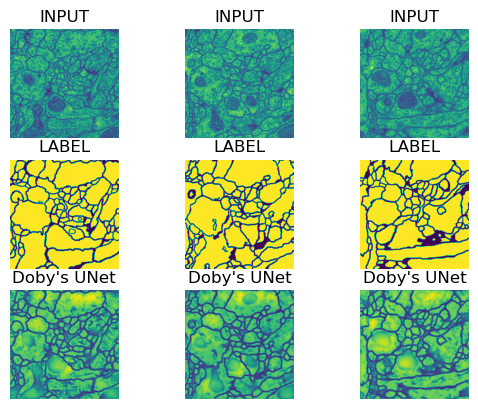

In [64]:
fig, axes = plt.subplots(output.shape[0], nframe_test)
    
for i in range(nframe_test):
    inputs2 = inputs[i]
    labels2 = labels[i]
    output2 = output[i]
    
    axes[0, i].imshow(inputs2)
    axes[0, i].set_title(f'INPUT')
    axes[0, i].axis('off')
    axes[1, i].imshow(labels2)
    axes[1, i].set_title(f'LABEL')
    axes[1, i].axis('off')
    axes[2, i].imshow(output2)
    axes[2, i].set_title(f'Doby\'s UNet')
    axes[2, i].axis('off')

plt.show()